# 1

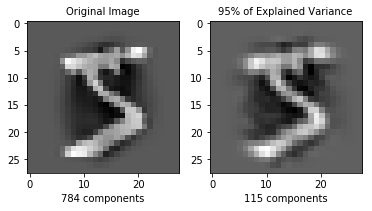

In [2]:
# References:
# 1. Image deskew: https://fsix.github.io/mnist/Deskewing.html

import timeit
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from scipy.ndimage import interpolation
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.linalg import svd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Functions to deskew the images
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix


def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

# Start the time to capture ru time
start = timeit.default_timer()

# Read the training data
data = np.genfromtxt("mnist_train.txt", delimiter=',')
label = data[:,0]
pixel = data[:,1:]

# Deskew the  training data data 
Deskewed_training_data =  deskewAll(pixel)

# Center the training data
center = preprocessing.StandardScaler(with_std=False).fit(Deskewed_training_data)
train_X = center.transform(Deskewed_training_data)

# Applying PCA to train data
pca = PCA(0.95)
pca = pca.fit(train_X)
reduced_data = pca.fit_transform(train_X) # This has reduced the data without loosing 95 % variance of the data.

approximation = pca.inverse_transform(reduced_data)

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(train_X[0].reshape(28,28),
              cmap = plt.cm.gray,interpolation='nearest')
plt.xlabel('784 components', fontsize = 10)
plt.title('Original Image', fontsize = 10);

# 115 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[0].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest');
plt.xlabel('115 components', fontsize = 10)
plt.title('95% of Explained Variance', fontsize = 10);


# Read the test data
data_2 = np.genfromtxt("mnist_test.txt", delimiter=',')

# Deskweing test data
Deskewed_test_data = deskewAll(data_2[:,1:])

# Centering test data
center_test = preprocessing.StandardScaler(with_std=False).fit(Deskewed_test_data)
test_X = center.transform(Deskewed_test_data)

# PCA tranformation
reduced_test_data = pca.transform(test_X)

# 2

In [3]:
final_error_rate =[]

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import time 
start_time = time.time()


data1 = np.genfromtxt("mnist_test.txt", delimiter=',')
test_label1 = data1[:,0]

Lr1=OneVsOneClassifier(LogisticRegression()).fit(reduced_data,label)



y_pred1=Lr1.predict(reduced_test_data)

accuracy_ovo=accuracy_score(test_label1,y_pred1)
error_rate1=1-accuracy_ovo
final_error_rate.append(error_rate1)
fm1 =confusion_matrix(test_label1,y_pred1)

print(fm1)

print("accuracy:",accuracy_ovo)
print("error rate:",error_rate1)
print("time: %s seconds" %(time.time()-start_time))


[[ 956    0    0    1    0    6    8    1    4    4]
 [   0 1122    5    2    0    1    2    1    2    0]
 [   8    3  985    8    4    2    3    3   15    1]
 [   0    0    8  973    0   12    0    6    7    4]
 [   1    3    7    1  941    5    3    1    3   17]
 [   3    0    0   10    2  863    4    0    8    2]
 [   9    3    7    1    8    7  919    0    3    1]
 [   0    1   12    1    5    1    0  992    1   15]
 [   6    1    6   10    4    8    2    3  927    7]
 [   4    3    3    8   22    4    1   15    2  947]]
accuracy: 0.9625
error rate: 0.03749999999999998
time: 102.85219478607178 seconds


# 3

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import time 
start_time = time.time()


data1 = np.genfromtxt("mnist_test.txt", delimiter=',')
test_label2 = data1[:,0]

Lr2=LogisticRegression(penalty='l1',multi_class='ovr').fit(reduced_data,label)



y_pred2=Lr2.predict(reduced_test_data)

accuracy_ovr=accuracy_score(test_label2,y_pred2)
error_rate2=1-accuracy_ovr
final_error_rate.append(error_rate2)



fm2 =confusion_matrix(test_label2,y_pred2)

print(fm2)

print("accuracy:",accuracy_ovr)
print("error rate:",error_rate2)
print("time: %s seconds" %(time.time()-start_time))


[[ 960    0    0    2    1    6    7    1    1    2]
 [   0 1122    2    1    0    1    4    0    4    1]
 [   7    1  970    7    5    1    5    7   29    0]
 [   1    1   10  961    1   14    0    7   12    3]
 [   2    1    4    2  935    2    4    3    8   21]
 [   5    0    1    6    6  845   10    1   14    4]
 [   9    2    5    1    8   13  916    0    3    1]
 [   2    2   15    0    7    0    0  972    6   24]
 [   9    1   10    8    7   13    3    2  913    8]
 [  11    4    3   14   29    4    0   18    7  919]]
accuracy: 0.9513
error rate: 0.048699999999999966
time: 165.27112317085266 seconds


# 4

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import time 
start_time = time.time()
data1 = np.genfromtxt("mnist_test.txt", delimiter=',')
test_label3 = data1[:,0]
Lr3=LogisticRegression(penalty='l2',multi_class='multinomial',solver='newton-cg').fit(reduced_data,label)
y_pred3=Lr3.predict(reduced_test_data)

accuracy_multinomial=accuracy_score(test_label3,y_pred3)
error_rate3=1-accuracy_multinomial
final_error_rate.append(error_rate3)

fm3 =confusion_matrix(test_label3,y_pred3)

print(fm3)

print("accuracy:",accuracy_multinomial)
print("error rate:",error_rate3)
print("time: %s seconds" %(time.time()-start_time))

[[ 957    0    3    2    0    8    7    1    1    1]
 [   0 1120    4    3    0    1    2    0    5    0]
 [   7    6  967   12    4    1    6    6   22    1]
 [   0    0    8  968    1    9    0    5   12    7]
 [   1    1    5    2  936    2    7    3    5   20]
 [   3    0    0    6    5  860    5    0   10    3]
 [   9    3    7    1   12    9  914    1    2    0]
 [   1    2   14    0    4    0    0  982    4   21]
 [   7    1    8    9    7   11    3    4  919    5]
 [   5    4    3   11   23    4    0   19    6  934]]
accuracy: 0.9557
error rate: 0.044300000000000006
time: 411.0030379295349 seconds


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


# 5

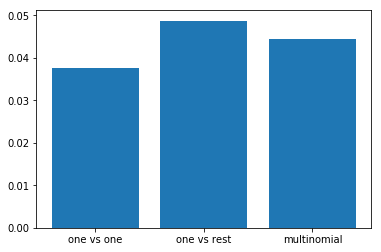

In [6]:
import matplotlib.pyplot as plt
#import matplotlib.pyplot.hist
x=np.arange(3)
plt.bar(x,height=final_error_rate)
plt.xticks(x,['one vs one','one vs rest','multinomial'])
plt.show()

# 6

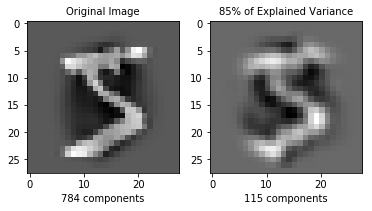

In [7]:
# References:
# 1. Image deskew: https://fsix.github.io/mnist/Deskewing.html

import timeit
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from scipy.ndimage import interpolation
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.linalg import svd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Functions to deskew the images
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix


def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

# Start the time to capture ru time
start = timeit.default_timer()

# Read the training data
data = np.genfromtxt("mnist_train.txt", delimiter=',')
label = data[:,0]
pixel = data[:,1:]

# Deskew the  training data data 
Deskewed_training_data =  deskewAll(pixel)

# Center the training data
center = preprocessing.StandardScaler(with_std=False).fit(Deskewed_training_data)
train_X = center.transform(Deskewed_training_data)

# Applying PCA to train data
pca = PCA(0.85)
pca = pca.fit(train_X)
reduced_data = pca.fit_transform(train_X) # This has reduced the data without loosing 95 % variance of the data.

approximation = pca.inverse_transform(reduced_data)

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(train_X[0].reshape(28,28),
              cmap = plt.cm.gray,interpolation='nearest')
plt.xlabel('784 components', fontsize = 10)
plt.title('Original Image', fontsize = 10);

# 115 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[0].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest');
plt.xlabel('115 components', fontsize = 10)
plt.title('85% of Explained Variance', fontsize = 10);


# Read the test data
data_2 = np.genfromtxt("mnist_test.txt", delimiter=',')

# Deskweing test data
Deskewed_test_data = deskewAll(data_2[:,1:])

# Centering test data
center_test = preprocessing.StandardScaler(with_std=False).fit(Deskewed_test_data)
test_X = center.transform(Deskewed_test_data)

# PCA tranformation
reduced_test_data = pca.transform(test_X)

# 7

In [8]:
final_error_rate1 =[]

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import time 
start_time = time.time()


data1 = np.genfromtxt("mnist_test.txt", delimiter=',')
test_label4 = data1[:,0]

Lr4=OneVsOneClassifier(LogisticRegression()).fit(reduced_data,label)



y_pred4=Lr4.predict(reduced_test_data)

accuracy_ovo1=accuracy_score(test_label4,y_pred4)
error_rate4=1-accuracy_ovo1
final_error_rate1.append(error_rate4)



fm4 =confusion_matrix(test_label4,y_pred4)

print(fm4)

print("accuracy:",accuracy_ovo1)
print("error rate:",error_rate4)
print("time: %s seconds" %(time.time()-start_time))


[[ 957    0    2    1    0    6    8    1    3    2]
 [   0 1118    4    2    0    2    3    0    6    0]
 [   6    0  985   11    3    1    3    6   17    0]
 [   1    1    4  975    1   12    0    5    8    3]
 [   2    0    3    2  947    0    6    1    5   16]
 [   4    0    0   12    3  856    8    1    6    2]
 [   6    3    4    1    5   10  926    1    1    1]
 [   1    2   13    0    1    0    0  994    2   15]
 [   4    0    7   10    4   12    4    2  926    5]
 [   0    4    1    7   18    5    1   19    4  950]]
accuracy: 0.9634
error rate: 0.036599999999999966
time: 31.602824926376343 seconds


# 8

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import time 
start_time = time.time()


data1 = np.genfromtxt("mnist_test.txt", delimiter=',')
test_label5 = data1[:,0]

Lr5=LogisticRegression(penalty='l1',multi_class='ovr').fit(reduced_data,label)



y_pred5=Lr5.predict(reduced_test_data)

accuracy_ovr1=accuracy_score(test_label5,y_pred5)
error_rate5=1-accuracy_ovr1
final_error_rate1.append(error_rate5)



fm5 =confusion_matrix(test_label5,y_pred5)

print(fm5)

print("accuracy:",accuracy_ovr1)
print("error rate:",error_rate5)
print("time: %s seconds" %(time.time()-start_time))


[[ 960    1    1    0    0    5    6    2    3    2]
 [   0 1114    2    2    0    1    4    1   11    0]
 [   5    3  950   13    9    3    4    6   38    1]
 [   1    1    8  962    1   13    0    6   12    6]
 [   1    0    8    2  930    2    7    3    8   21]
 [  13    2    1    8    8  835    8    2   11    4]
 [   8    3    8    2    8   16  909    0    3    1]
 [   2    4   15    1    3    1    0  978    3   21]
 [   4    1   10    8    5   15    7    4  909   11]
 [  10    5    2   13   31    2    1   23    9  913]]
accuracy: 0.946
error rate: 0.05400000000000005
time: 38.07373023033142 seconds


# 9

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
import numpy as np
import time 
start_time = time.time()



data1 = np.genfromtxt("mnist_test.txt", delimiter=',')
test_label6 = data1[:,0]



Lr6=LogisticRegression(penalty='l2',multi_class='multinomial',solver='newton-cg').fit(reduced_data,label)



y_pred6=Lr6.predict(reduced_test_data)

accuracy_multinomial1=accuracy_score(test_label6,y_pred6)
error_rate6=1-accuracy_multinomial1
final_error_rate1.append(error_rate6)

fm6 =confusion_matrix(test_label6,y_pred6)

print(fm6)

print("accuracy:",accuracy_multinomial1)
print("error rate:",error_rate6)
print("time: %s seconds" %(time.time()-start_time))

[[ 957    0    1    0    0    8    7    2    3    2]
 [   0 1114    1    3    0    1    5    0   11    0]
 [   6    2  955   17    9    3    4    8   27    1]
 [   2    1    9  969    0   11    0    4    9    5]
 [   1    0    4    2  932    3    8    5    6   21]
 [   7    0    0    9    4  851    7    1   11    2]
 [  10    3    8    1   13   14  903    4    2    0]
 [   1    3   15    2    3    1    0  979    6   18]
 [   4    1    8   10    6   17    3    4  914    7]
 [   4    4    1   12   23    1    1   20   10  933]]
accuracy: 0.9507
error rate: 0.04930000000000001
time: 239.20563650131226 seconds


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


# 10

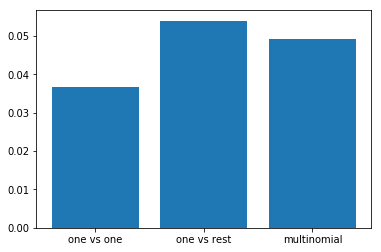

In [11]:
import matplotlib.pyplot as plt
#import matplotlib.pyplot.hist
x=np.arange(3)
plt.bar(x,height=final_error_rate1)
plt.xticks(x,['one vs one','one vs rest','multinomial'])
plt.show()

# 11

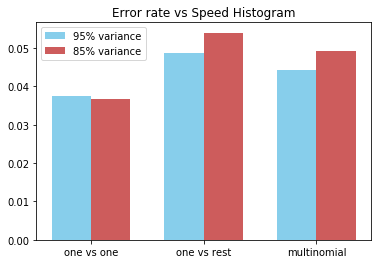

In [12]:
import matplotlib.pyplot as plt
#import matplotlib.pyplot.hist
x = np.arange(3)
width = 0.35

ax = plt.subplot(111)
ax.bar(x - width/2, final_error_rate, width=width, color='SkyBlue', align='center', label='95% variance')
ax.bar(x + width/2, final_error_rate1, width=width, color='IndianRed', align='center', label='85% variance')
ax.set_title('Error rate vs Speed Histogram')
ax.set_xticks(x)
ax.set_xticklabels(('one vs one','one vs rest','multinomial'))
ax.legend()

plt.show()

In [13]:
import pandas as pd
from itertools import cycle
from scipy import interp

n_classes=10
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ =  roc_curve(np.array(pd.get_dummies(test_label1))[:, i], np.array(pd.get_dummies(y_pred1))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic regression')
plt.legend(loc="lower right")
plt.show()

NameError: name 'roc_curve' is not defined